In [1]:
import os
from typing import Dict
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

In [2]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [3]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

**Breakpoints**

In [4]:
class State(MessagesState):
    question: str
    answer: str

In [5]:
llm_with_tools = llm.bind_tools([web_search])

In [6]:
def entry_point(state: State):
    question = state["question"]
    system_message = SystemMessage("You conduct web search to respond to user's questions")
    human_message = HumanMessage(question)
    messages = [system_message, human_message]
    return {"messages": messages}

In [7]:
def agent(state: State):
    messages = state["messages"]
    ai_message = llm_with_tools.invoke(messages)
    return {"messages": ai_message, "answer": ai_message.content}

In [8]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [9]:
workflow = StateGraph(State)
workflow.add_node("entry_point", entry_point)
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode([web_search]))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "agent")
workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)
workflow.add_edge("tools", "agent")

In [10]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["tools"], 
    checkpointer=memory
)

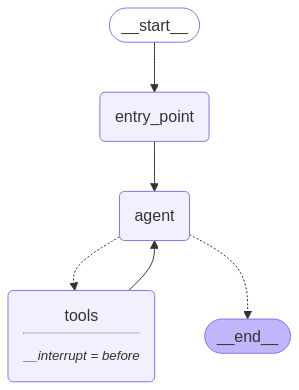

In [11]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [12]:
input_question = {"question": "what's the capital of Brazil?"}
config = {"configurable": {"thread_id": 1}}

In [13]:
for event in graph.stream(input=input_question, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_bPFHlnE43nzLSiEa9IpJWpeY)
 Call ID: call_bPFHlnE43nzLSiEa9IpJWpeY
  Args:
    question: capital of Brazil


In [14]:
state = graph.get_state(config=config)

In [15]:
state

StateSnapshot(values={'messages': [SystemMessage(content="You conduct web search to respond to user's questions", additional_kwargs={}, response_metadata={}, id='e89b7b04-30c5-4850-b2c5-23d2356ba812'), HumanMessage(content="what's the capital of Brazil?", additional_kwargs={}, response_metadata={}, id='2ba37ea2-5ba3-4c4f-aac7-fb079a3f4e62'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bPFHlnE43nzLSiEa9IpJWpeY', 'function': {'arguments': '{"question":"capital of Brazil"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 64, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'finish_reason': 'tool_calls', 'logprobs': None},

In [16]:
state.next

('tools',)

In [17]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  web_search (call_bPFHlnE43nzLSiEa9IpJWpeY)
 Call ID: call_bPFHlnE43nzLSiEa9IpJWpeY
  Args:
    question: capital of Brazil
================================= Tool Message =================================
Name: web_search

{"query": "capital of Brazil", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Brasília - Wikipedia", "url": "https://en.wikipedia.org/wiki/Brasília", "content": "445 Region Latin America and the Caribbean Brasília (/brəˈzɪliə/ brə-ZIL-ee-ə,[4][5] Portuguese: [bɾaˈzili.ɐ, bɾaˈziljɐ] ⓘ) is the capital city of Brazil. Located in the Brazilian highlands in the country's Central-West region, it is the seat of government of the Federal District. It was founded by President Juscelino Kubitschek on 21 April 1960, to replace Rio de Janeiro as the national capital. [6] Brasília is a planned city developed by Lúcio Costa, Oscar Niemeyer and Joaquim Ca

**Human Approval**

In [18]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()
    
    human_input = input("Do you approve the tool calling? (YES or NO): ")
    if human_input.lower() == "yes":
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    
    else:
        SystemMessage("Workflow aborted by a human").pretty_print()

In [19]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=2,
)

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_h57WRVMC3dqxnUPhK6ax3MoA)
 Call ID: call_h57WRVMC3dqxnUPhK6ax3MoA
  Args:
    question: capital of Brazil
================================== Ai Message ==================================
Tool Calls:
  web_search (call_h57WRVMC3dqxnUPhK6ax3MoA)
 Call ID: call_h57WRVMC3dqxnUPhK6ax3MoA
  Args:
    question: capital of Brazil
================================= Tool Message =================================
Name: web_search

{"query": "capital of Brazil", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Brasília - Wikipedia", "url": "https://en.wikipedia.org/wiki/Brasília", "content": "445 Region Latin America and the Caribbean Brasília (/brəˈzɪliə/ brə-ZIL-ee-ə,[4][5] Portuguese: [bɾaˈzili.ɐ, bɾaˈziljɐ] ⓘ) is the capital city of Brazil. L

In [20]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Mexico?",
    thread_id=3,
)

================================ Human Message =================================

what's the capital of Mexico?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_TwwanThRjTslgX9yiDPikEpY)
 Call ID: call_TwwanThRjTslgX9yiDPikEpY
  Args:
    question: capital of Mexico
================================ System Message ================================

Workflow aborted by a human


**Human Revision**

In [21]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["agent"], 
    checkpointer=memory
)

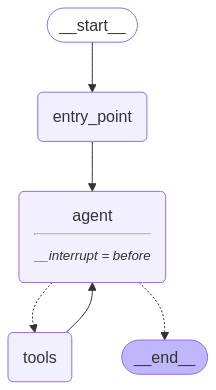

In [22]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [23]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you want to proceed with this question? (YES or NO): ")
    
    if human_input.lower() == "no":
        human_input = input("So what should be the question? ")
        human_message = HumanMessage(content=human_input)
        system_message = SystemMessage("Workflow edited by a human")
        system_message.pretty_print()
        graph.update_state(
            config=config,
            values={
                "messages": [
                    system_message,
                    human_message,
                ]
            },
        )

        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    
    for event in graph.stream(input=None, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()


In [24]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=4,
)

================================ Human Message =================================

what's the capital of Brazil?
================================ System Message ================================

Workflow edited by a human
================================ Human Message =================================

What's the capital of Canada?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_H3KzdekWF8lNU2ZhiNU4Qcvp)
 Call ID: call_H3KzdekWF8lNU2ZhiNU4Qcvp
  Args:
    question: What is the capital of Canada?
================================= Tool Message =================================
Name: web_search

{"query": "What is the capital of Canada?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What Is The Capital City Of Canada? - WorldAtlas", "url": "https://www.worldatlas.com/articles/what-is-the-capital-of-canada.html", "content": "What Is The Capital City Of Canada? What Is The Capital City Of Can

In [25]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=5,
)

================================ Human Message =================================

what's the capital of Brazil?
================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_1HUf1PJblYcTggvDBvLpUk5A)
 Call ID: call_1HUf1PJblYcTggvDBvLpUk5A
  Args:
    question: What is the capital of Brazil?
================================= Tool Message =================================
Name: web_search

{"query": "What is the capital of Brazil?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Brasília - Wikipedia", "url": "https://en.wikipedia.org/wiki/Brasília", "content": "445 Region Latin America and the Caribbean Brasília (/brəˈzɪliə/ brə-ZIL-ee-ə,[4][5] Portuguese: [bɾaˈzili.ɐ, bɾaˈziljɐ] ⓘ) is the capital city of Brazil. Located in the Brazilian highlands in the country's Central-West region, it is th